EnvSpec(
│   id='MountainCarContinuous-v0',
│   entry_point='gymnasium.envs.classic_control.continuous_mountain_car:Continuous_MountainCarEnv',
│   reward_threshold=90.0,
│   nondeterministic=False,
│   max_episode_steps=999,
│   order_enforce=True,
│   autoreset=False,
│   disable_env_checker=False,
│   apply_api_compatibility=False,
│   kwargs={'render_mode': 'rgb_array'},
│   namespace=None,
│   name='MountainCarContinuous',
│   version=0,
│   additional_wrappers=(),
│   vector_entry_point=None
)

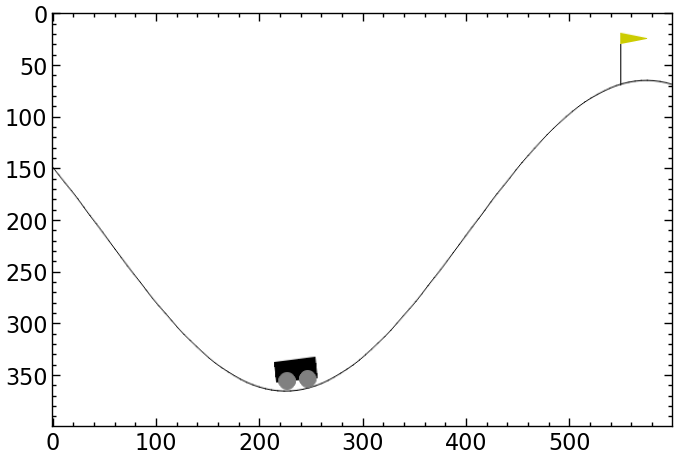

In [1]:
import os
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import matplotlib.pyplot as plt
import scienceplots
from rich.pretty import pprint
import jax
import jax.numpy as jnp
import numpy as np

plt.style.use(['science', 'notebook'])
import mediapy

import gymnasium as gym

mountain_car = gym.make("MountainCarContinuous-v0", render_mode='rgb_array')
# [position, velocity]
obs, info = mountain_car.reset()
plt.imshow(mountain_car.render())
mountain_car.close()

GLOBAL_KEY = jax.random.key(42)

pprint(mountain_car.spec)

In [2]:
obs, rew, terminated, truncated, info = mountain_car.step(np.random.normal(size=1))

In [3]:
class PenalizeLeftMovementCar(gym.Env):
    def __init__(self, custom_reward=False, **kwargs):
        self.inner_env = gym.make("MountainCarContinuous-v0", **kwargs)
        self.observation_space = self.inner_env.observation_space
        self.action_space = self.inner_env.action_space
        self.render_mode = kwargs.get('render_mode') if not None else 'rgb_array'
        self.spec = self.inner_env.spec
        self.custom_reward = custom_reward
        self.num_bad_acts = 0
        
    def reset(self, *, seed = None, options = None):
        return self.inner_env.reset()
    
    def step(self, action):
        observation, reward, terminated, truncated, info = self.inner_env.step(action)
        if self.custom_reward:
            if action < 0:
                reward -= 0.5
                self.num_bad_acts += 1
        return observation, reward, terminated, truncated, info
    
    def render(self):
        return self.inner_env.render()
    
    def close(self):
        return self.inner_env.close()

env = PenalizeLeftMovementCar(render_mode='rgb_array', custom_reward=True)
env.reset()
# plt.imshow(env.render())
# env.close()

(array([-0.5268182,  0.       ], dtype=float32), {})

# Successor Features

In [10]:
import flashbax as fbx
import jax.numpy as jnp

# At first, use custom engineered feature vector for each (s, a) + meta info
def feature_vector(position, action, velocity):
    f1 = jnp.array([position])
    f2 = jnp.array([velocity])
    f3 = jnp.array([position ** 2])
    f4 = jnp.array([velocity ** 2])
    f5 = jnp.array([position * velocity])
    f6 = action[None]
    f7 = f6 * position
    f8 = f6 * velocity
    f9 = 0.45 - jnp.array([position])
    f10 = jnp.sign(action)[None]
    f11 = (f2 ** 2) / 2.0
    return jnp.stack([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11]).squeeze()
    
buffer = fbx.make_item_buffer(
    max_length=10_000,
    min_length=100,
    sample_batch_size=64,
    add_sequences=False
)
init_sample = {"obs": np.array([0.0, 0.0]), "next_obs": np.array([0.0, 0.0]),
               "action": np.array([0.0]), "feature": np.zeros(shape=11),
               "reward": np.array(0.0), "mask": np.array(0.0)}
state = buffer.init(init_sample)

In [11]:
render = []
for episode_num in range(1):
    done = False
    observation, info = env.reset()
    while not done:
        action = env.action_space.sample()
        cur_obs = observation
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = jax.jit(buffer.add)(state, {"obs": cur_obs, "action": action, "next_obs": observation,
                           "feature": feature_vector(observation[0], action.squeeze(), observation[1]), "reward": reward, "mask":  1 - float(done)})
        render.append(env.render())
        if done:
            env.reset()
env.close()

In [12]:
mediapy.show_video(
    render
)

In [13]:
batch = buffer.sample(state, jax.random.key(42))

In [21]:
import flax
import flax.linen as nn
import flax.struct
from impls.utils.flax_utils import ModuleDict, TrainState
from impls.utils.networks import ensemblize
import optax
from typing import Any
from jaxtyping import *


class PsiNet(flax.linen.Module):
    hidden_layers: list[int] = (256, 256)
    
    @nn.compact
    def __call__(self, state, action):
        x = jnp.concatenate([state, action], -1)
        for idx, num_feat in enumerate(self.hidden_layers):
            sf = nn.Dense(num_feat)(x)
            if idx != len(self.hidden_layers) - 1:
                sf = jax.nn.relu(sf)
        return sf
    
class SFAgent(flax.struct.PyTreeNode):
    rng: Key
    network: TrainState
    target_network: TrainState
    tau: float = 0.005
    
    @jax.jit
    def update(self, batch):
        def loss_fn(params):
            next_feat = self.target_network(batch['next_obs'], batch['action'])
            target_feat = batch['feature'] + 0.99 * batch['mask'][:, None] * next_feat
            q = self.network(batch['obs'], batch['action'], params=params)
            loss = (q - target_feat) ** 2
            #loss = ((q1 - target_feat) ** 2 + (q2 - target_feat) ** 2)
            return loss.mean(), {}
        
        new_state, info = self.network.apply_loss_fn(loss_fn=loss_fn)
        new_target = self.target_update(new_state, self.target_network)
        return self.replace(network=new_state, target_network=new_target), info
    
    def target_update(self, network, target_net):
        new_target_params = jax.tree_util.tree_map(
            lambda p, tp: p * self.tau + tp * (1 - self.tau),
            network.params,
            target_net.params,
        )
        return target_net.replace(params=new_target_params)

    
    @classmethod
    def create(cls,
            seed,
            ex_obs,
            ex_actions,
        ):
        
        key = jax.random.PRNGKey(seed)
        key, net_key, target_net_key = jax.random.split(key, 3)
        
        psi_net_def = PsiNet(hidden_layers=(64, 64, 11)) #ensemblize(PsiNet, num_qs=2)(hidden_layers=(64, 64, 11))
        target_psi_net_def = PsiNet(hidden_layers=(64, 64, 11))
        
        network_tx = optax.adam(learning_rate=3e-4)
        net_params = psi_net_def.init(net_key, ex_obs, ex_actions)['params'] 
        net_state = TrainState.create(
            model_def=psi_net_def,
            params=net_params,
            tx=network_tx
        )
        target_net_state = TrainState.create(
            model_def=target_psi_net_def,
            params=net_params#jax.tree.map(lambda _: _[0], net_params)
        )
        return cls(rng=key, network=net_state, target_network=target_net_state)
    
    def compute_sfs(self, *args):
        return self.network(*args)


In [22]:
agent = SFAgent.create(
    42,
    env.observation_space.sample(),
    env.action_space.sample()
)

In [23]:
positions = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 100)
velocities = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 100)

grid = np.array(np.meshgrid(positions, velocities)).T.reshape(-1, 2)
action = np.random.uniform(low=-1.0, high=1.0, size=(grid.shape[0], )) #np.linspace(-1, 1, 100)[:, None]#

psi_values = agent.compute_sfs(grid, action[:, None])
# Test
test_w_sign = np.zeros(11)
test_w_sign[[5, 9]] = np.array([1.0, 1.0])
features = feature_vector(grid[:, 0], action, grid[:, 1]).T
test_rewards = (features @ test_w_sign).reshape(-1, 1)

psi_values = (psi_values @ test_w_sign).reshape(-1, 1)

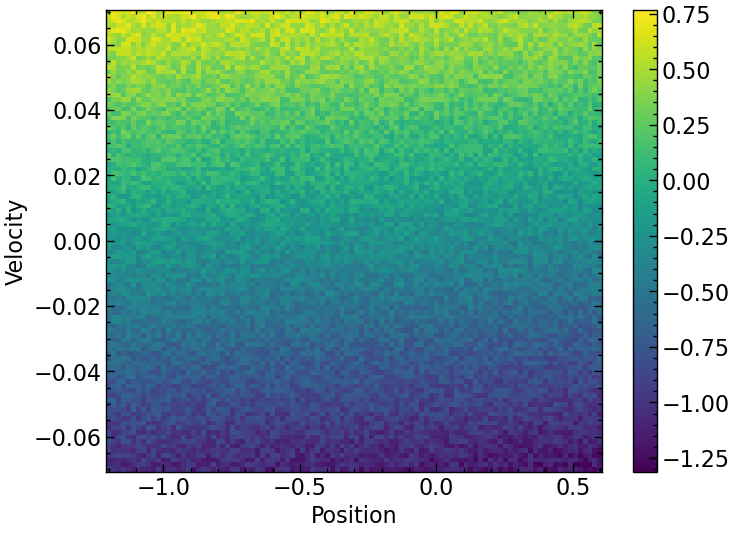

In [26]:
fig, ax = plt.subplots()
x, y = np.meshgrid(positions, velocities)
plt.pcolormesh(x, y, psi_values.reshape(100, 100), cmap='viridis')
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.colorbar()

In [ ]:
from tqdm.auto import tqdm

pbar = tqdm(range(10_000), colour='green')
for i in pbar:
    sample_key = jax.random.fold_in(GLOBAL_KEY, i)
    batch = jax.jit(buffer.sample)(state, sample_key)
    agent, info = agent.update(batch.experience)

  0%|          | 0/10000 [00:00<?, ?it/s]